<a href="https://colab.research.google.com/github/austin-strom/text2face/blob/main/TFImageCap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [68]:
!gdown --id 1nD6kNAgIVjxpzIScJNLqUyRA1qEkc4Op
!gdown --id 1cwcYbl0dhXEzmdbee_K_H6jcndbsxT2o         

!unzip -u -q face2text_v0.1.zip -d face2text_v0.1
!unzip -u -q face2text_v1.0.zip -d face2text_v1.0

Downloading...
From: https://drive.google.com/uc?id=1nD6kNAgIVjxpzIScJNLqUyRA1qEkc4Op
To: /content/face2text_v0.1.zip
100% 156k/156k [00:00<00:00, 54.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cwcYbl0dhXEzmdbee_K_H6jcndbsxT2o
To: /content/face2text_v1.0.zip
100% 217k/217k [00:00<00:00, 76.8MB/s]


In [69]:
# # This is moving the v0.1 file to the proper data dir for testing

!mkdir face2text_v0.1/data
# !mv face2text_v0.1/ Face2Text/.

!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xvf lfw.tgz
!mv lfw face2text_v0.1/data/.

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Aiken/Clay_Aiken_000

In [70]:
import json
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


filename = "face2text_v0.1/clean.json"
# load descriptions
doc = load_doc(filename)
with open(filename) as f:
    annotations = json.load(f)
# jj = json.dumps(doc[1:-1])
print(annotations)
image_path = 'face2text_v0.1/data/lfw/'


[{'img_id': 1, 'image': 'Katerina_Smrzova/Katerina_Smrzova_0001.bmp', 'descriptions': [{'desc_id': 582, 'text': 'A young woman with long light brown hair cut in layers and parted in the middle, a small nose and a nice open smile.'}, {'desc_id': 1326, 'text': 'A young girl posing for the camera'}]}, {'img_id': 2, 'image': 'John_Rowland/John_Rowland_0001.bmp', 'descriptions': [{'desc_id': 178, 'text': 'Middleaged man - very traditional square jawed american features looking pensive or waiting for a result of somesort. looks like a politician'}, {'desc_id': 851, 'text': 'brown/greyish hair, brown eyes'}]}, {'img_id': 3, 'image': 'Laurent_Gbagbo/Laurent_Gbagbo_0001.bmp', 'descriptions': [{'desc_id': 815, 'text': 'A serious man, most probably politically involved. Whiting hair with intense eyes. Smart and looks important'}, {'desc_id': 1138, 'text': "Coloured man in his late 50's, dressed in suit and tie. Salt and pepper hair and round pleasant face."}, {'desc_id': 1243, 'text': 'Dark skin,

In [71]:
print(type(annotations))
print(type(annotations[0]['descriptions']))

<class 'list'>
<class 'list'>


In [72]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for img in annotations:
  for val in img['descriptions']:
    caption = f"<start> {val['text']} <end>"
    image_path_full = image_path + img['image'].replace('bmp','jpg')
    image_path_to_caption[image_path_full].append(caption)


In [73]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))
print(train_image_paths)


400
['face2text_v0.1/data/lfw/Alma_Powell/Alma_Powell_0001.jpg', 'face2text_v0.1/data/lfw/Andreas_Vinciguerra/Andreas_Vinciguerra_0001.jpg', 'face2text_v0.1/data/lfw/Laurie_Pirtle/Laurie_Pirtle_0001.jpg', 'face2text_v0.1/data/lfw/Jack_Osbourne/Jack_Osbourne_0001.jpg', 'face2text_v0.1/data/lfw/Leon_Barmore/Leon_Barmore_0001.jpg', 'face2text_v0.1/data/lfw/Lina_Krasnoroutskaya/Lina_Krasnoroutskaya_0001.jpg', 'face2text_v0.1/data/lfw/Lindsay_Davenport/Lindsay_Davenport_0001.jpg', 'face2text_v0.1/data/lfw/Joe_Pantoliano/Joe_Pantoliano_0001.jpg', 'face2text_v0.1/data/lfw/Junko_Tabei/Junko_Tabei_0001.jpg', 'face2text_v0.1/data/lfw/Cristina_Torrens_Valero/Cristina_Torrens_Valero_0001.jpg', 'face2text_v0.1/data/lfw/Antonio_Banderas/Antonio_Banderas_0001.jpg', 'face2text_v0.1/data/lfw/Lee_Ann_Terlaji/Lee_Ann_Terlaji_0001.jpg', 'face2text_v0.1/data/lfw/Jessica_Alba/Jessica_Alba_0001.jpg', 'face2text_v0.1/data/lfw/John_Rowland/John_Rowland_0001.jpg', 'face2text_v0.1/data/lfw/Katie_Wagner/Katie_Wag

In [74]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))


In [75]:
print(train_captions)
print(img_name_vector)
print(caption_list)
# Image.open(img_name_vector[0])


['<start> Excited either was mentioned in a concert or just happy jolly woman <end>', '<start> Confident, hair pulled back,with make up, nice teeth and big broad smile, asian looking, middle aged, female <end>', '<start> a lady in her 60ies with dyed brown hair, her oval frameless glasses, looking proud and very happy. like having a women on hrt as her type of completion and make looks very well kept. her nose is slightly pointed. her eyebrows are made. <end>', '<start> Male late 30dark brown hair longer nose small eyes big ears sportsman <end>', '<start> a 30-something year old man with brown messy hair, with an expressive face of effort - seems like he is a tennis player <end>', '<start> Young man, olive shined, dark unruly hair cur short . Long face with small dark eyes. Looking wide eyed like he is running, Face is strained with wrinkles on his forehead and mouth open. White regular teeth, long narrow nose and slightly protruding ears. Cleft wide chin with wrinkles on either side, 

# Preprocess images

In [76]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    # print(np.shape(img))

    img = tf.image.decode_jpeg(img, channels=3)
    # print(np.shape(img))

    img = tf.image.resize(img, (128, 128))
    # print(np.shape(img))

    img = tf.keras.applications.inception_v3.preprocess_input(img)
    # print(np.shape(img))

    return img, image_path

def prep_image(image_tensor):
    img = tf.image.resize(image_tensor, (128,128))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


In [77]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


In [78]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


# Preprocess and Tokenize cations

In [79]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


In [80]:
# Choose the top 5000 words from the vocabulary
top_k = 2000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [81]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)


In [82]:
print(max_length)

94


# Split Data

In [83]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.9)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])


In [84]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(1116, 1116, 121, 121)

# Create tf.data dataset

In [85]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 256
units = 1024
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
val_num_steps = len(img_name_val) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64


In [86]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


In [87]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [88]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


# Model

In [89]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, x):
    features = x[0]
    hidden = x[1]
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


In [90]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [91]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.dropout = tf.keras.layers.Dropout(0.25)
    self.attention = BahdanauAttention(self.units)

  def call(self, x):
    features = x[1]
    hidden = x[2]
    x = x[0]
    # defining attention as a separate model
    context_vector, attention_weights = self.attention([features, hidden])

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    x = self.dropout(x)
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [92]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.7)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# How the losss works:
# Takes batch of what the next word is in the sequence (real) and of the predicted values from the vocab (pred)
# real = index of next word
# pred = all vocab words ranked by conditional probability that they are the next word
# mask = 1 or 0 on whether the value of real is 0 (<pad>)
# return mean loss of batch (mask*loss_object(real, pred))
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  mask *= 0.6
  mask += 0.2
  loss_ *= mask
  # print(tf.reduce_mean(loss_))

  return tf.reduce_mean(loss_)


In [93]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


# Checkpoints

In [94]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)
checkpoint_path = "./checkpoints/train"
checkpoint_path = '/content/drive/MyDrive/TextToFace/checkpoints'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


import pickle

tokenizer_location = '/content/drive/MyDrive/TextToFace/Test3'
checkpoint_path = '/content/drive/MyDrive/TextToFace/'
# saving tokenizer
with open(tokenizer_location + 'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [95]:
start_epoch = 0
reset_checkpoints = True
if ckpt_manager.latest_checkpoint and not reset_checkpoints:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) * 5
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

print(start_epoch)

0


In [96]:
saving_encoder_path = '/content/drive/MyDrive/TextToFace/Test3/encoder'
saving_decoder_path = '/content/drive/MyDrive/TextToFace/Test3/decoder'
load_model = False

In [97]:
if load_model:
  encoder.load_weights(saving_encoder_path)
  decoder.load_weights(saving_decoder_path)

  # loading
  with open(tokenizer_location + 'tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)

# Training

In [98]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [99]:
# @tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      # Going through each word of each sequence in the batch
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          x = [dec_input, features, hidden]
          predictions, hidden, _ = decoder(x)
          loss += loss_function(target[:, i], predictions)
          # print(loss)
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

def validate(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  features = encoder(img_tensor)

  # Going through each word of each sequence in the batch
  for i in range(1, target.shape[1]):
      # passing the features through the decoder
      x = [dec_input, features, hidden]
      predictions, hidden, _ = decoder(x)
      loss += loss_function(target[:, i], predictions)
      # print(loss)
      # using teacher forcing
      dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))


  return loss, total_loss

In [100]:
EPOCHS = 50
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
val_loss_set = []
early_stop_count = 0
best_val = 50000
if EPOCHS > 0:
  for epoch in range(start_epoch, EPOCHS + start_epoch):
      start = time.time()
      total_loss = 0
      val_total_loss = 0
      for (batch, (img_tensor, target)) in enumerate(dataset):
          # print(img_tensor.numpy().shape)
          # print(target[:, 0].numpy())
          batch_loss, t_loss = train_step(img_tensor, target)
          total_loss += t_loss

          if batch % 100 == 0:
              average_batch_loss = batch_loss.numpy()/int(target.shape[1])
              print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

      # storing the epoch end loss value to plot later
      loss_plot.append(total_loss / num_steps)

      for (batch, (img_tensor, target)) in enumerate(val_dataset):
          # print(img_tensor.numpy().shape)
          # print(target[:, 0].numpy())
          batch_loss, val_t_loss = validate(img_tensor, target)
          val_total_loss += val_t_loss

      val_loss_set.append(val_total_loss/val_num_steps)

      print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
      print(f'Validation loss: {val_total_loss/val_num_steps:.6f}')
      print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
      if val_loss_set[-1] >= best_val:
          early_stop_count += 1
      else:
          early_stop_count = 0
          best_val = val_loss_set[-1]
          ckpt_manager.save()
      
      if early_stop_count > 4 and epoch > 20:
          print('Early Stopping')
          break

ckpt.restore(ckpt_manager.latest_checkpoint)

# sess.close()

Epoch 1 Batch 0 Loss 2.7678


KeyboardInterrupt: ignored

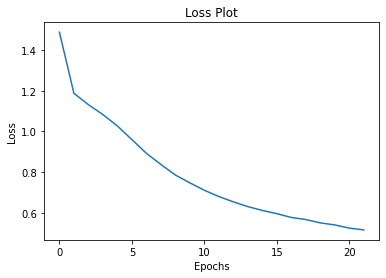

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


# Evaluation

In [ ]:
def evaluate(image, real=None):
    # attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # print(temp_input.shape)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    loss = 0
    predicted_done = False
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder([dec_input,
                                                         features,
                                                         hidden])
        # print(predictions)
        # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        loss += loss_function(real[i], predictions)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

        if predicted_done:
            predicted_id = 0
        else:
            result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            predicted_done = True
        
        dec_input = tf.expand_dims([predicted_id], 0)
    # attention_plot = attention_plot[:len(result), :]
    # print(predictions)
    # print(tokenizer.index_word[predicted_id])
    print(real.shape[0])
    loss = loss/real.shape[0]
    return result,loss


In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

def image_display(image):
    temp_image = np.array(Image.open(image))

    plt.imshow(temp_image)


94
loss:  tf.Tensor(1.3055615, shape=(), dtype=float32)
Real Caption: <start> a young woman who seems to be very happy with an <unk> she just got <end>
Prediction Caption: a young woman with <unk> his eyes and <unk> on the <unk> jubilant of a young athlete <unk> <end>


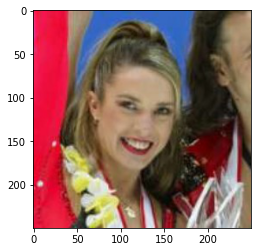

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
captions = [real_caption, real_caption]

# for caption in captions:

#   print(caption.split())
# import torch
# test = torch.Tensor([[tokenizer.word_index[i] for i in caption.split()] for caption in captions])
# test1 = test[1]
# print(test1[1])
# print(test1[1]*2

result, loss = evaluate(image, real=tf.Variable([i for i in cap_val[rid]]))
print("loss: ", loss)
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
# loss_function(real_caption, result)
# plot_attention(image, result, attention_plot)
image_display(image)

In [ ]:
cap_ten = tf.Variable(cap_val)
print(cap_ten)
real_caption = [' '.join([tokenizer.index_word[i]
                for i in caption if i not in [0]]) for caption in cap_ten.numpy()]


<tf.Variable 'Variable:0' shape=(127, 94) dtype=int32, numpy=
array([[  3,  48,  23, ...,   0,   0,   0],
       [  3,   2,  23, ...,   0,   0,   0],
       [  3,   2,  43, ...,   0,   0,   0],
       ...,
       [  3, 240, 144, ...,   0,   0,   0],
       [  3, 451, 804, ...,   0,   0,   0],
       [  3,   2,  53, ...,   0,   0,   0]], dtype=int32)>


# Save Model

In [ ]:
encoder.save_weights(saving_encoder_path)
decoder.save_weights(saving_decoder_path)


In [ ]:
(tokenizer.index_word[0])


# Model Format of eveything needed (I think)

In [ ]:
# Model
import pickle
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, x):
    features = x[0]
    hidden = x[1]
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x):
    features = x[1]
    hidden = x[2]
    x = x[0]
    # defining attention as a separate model
    context_vector, attention_weights = self.attention([features, hidden])

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


def prep_image(image_tensor):
    img = tf.image.resize(image_tensor, (128,128))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

class ImgCapModel(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    self.encoder = CNN_Encoder(embedding_dim)
    self.decoder = RNN_Decoder(embedding_dim, units, vocab_size)

    image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                    weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output

    self.image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
    self.optimizer = tf.keras.optimizers.Adam()
    self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')


  def load(self, encoder_path, decoder_path, tokenizer_location):
    self.encoder.load_weights(encoder_path)
    self.decoder.load_weights(decoder_path)
    # loading
    with open(tokenizer_location, 'rb') as handle:
        self.tokenizer = pickle.load(handle)

  def evaluate(self, image_tensor):
    hidden = self.decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(prep_image(image_tensor)[0], 0)
    img_tensor_val = self.image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = self.encoder(img_tensor_val)

    dec_input = tf.expand_dims([self.tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder([dec_input,
                                          features,
                                          hidden])

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(self.tokenizer.index_word[predicted_id])

        if self.tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

  def loss_function(self, real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = self.loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

  def call(self, x):
      loss = 0

      # initializing the hidden state for each batch
      # because the captions are not related from image to image
      hidden = decoder.reset_state(batch_size=target.shape[0])

      dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

      with tf.GradientTape() as tape:
          features = encoder(img_tensor)

          # Going through each word of each sequence in the batch
          for i in range(1, target.shape[1]):
              # passing the features through the decoder
              x = [dec_input, features, hidden]
              predictions, hidden, _ = decoder(x)
              loss += loss_function(target[:, i], predictions)
              # print(loss)
              # using teacher forcing
              dec_input = tf.expand_dims(target[:, i], 1)

      total_loss = (loss / int(target.shape[1]))

      trainable_variables = encoder.trainable_variables + decoder.trainable_variables

      gradients = tape.gradient(loss, trainable_variables)

      optimizer.apply_gradients(zip(gradients, trainable_variables))

      return loss, total_loss

In [ ]:
# Variables used in model
top_k = 5000

# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

model = ImgCapModel(embedding_dim, units, vocab_size)
